In [2]:
from transformers import pipeline
modelo = "CIDAS/clipseg-rd64-refined"
segmentador = pipeline("image-segmentation", model=modelo)

The model 'CLIPSegForImageSegmentation' is not supported for image-segmentation. Supported models are ['DetrForSegmentation', 'BeitForSemanticSegmentation', 'Data2VecVisionForSemanticSegmentation', 'DPTForSemanticSegmentation', 'MobileNetV2ForSemanticSegmentation', 'MobileViTForSemanticSegmentation', 'MobileViTV2ForSemanticSegmentation', 'SegformerForSemanticSegmentation', 'UperNetForSemanticSegmentation', 'MaskFormerForInstanceSegmentation', 'Mask2FormerForUniversalSegmentation', 'OneFormerForUniversalSegmentation'].


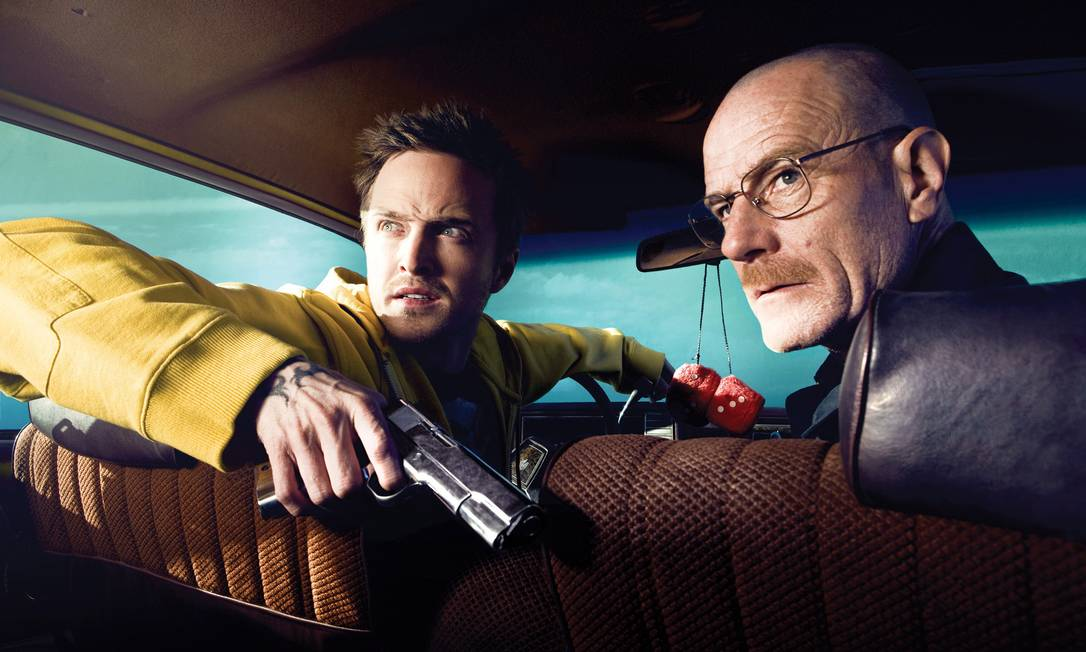

In [17]:
from pathlib import Path
from PIL import Image

# imagem = Image.open(Path('imagens/cidades/city.jpg'))
imagem = Image.open(Path('imagens/cidades/breaking-bad.jpg'))

imagem

In [4]:
segmentacao = segmentador(imagem)

ValueError: Invalid conditional, should be either provided as `input_ids` or `conditional_pixel_values`

In [5]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [23]:
prompts = ["gun", "glasses"]

inputs = processor(
    text=prompts,
    images=[imagem] * len(prompts),
    padding=True,
    return_tensors="pt",
)

Unused or unrecognized kwargs: padding.


In [24]:
import torch

# Faz a segmentação aqui
with torch.no_grad():
  outputs = model(**inputs)

predicoes = outputs.logits.unsqueeze(1)

In [25]:
predicoes

tensor([[[[-7.9829, -7.9186, -7.7762,  ..., -8.1576, -8.1839, -8.2652],
          [-7.8811, -7.5825, -7.5813,  ..., -8.0757, -8.1699, -8.1933],
          [-7.6128, -7.3915, -7.4307,  ..., -7.8688, -7.9878, -8.0551],
          ...,
          [-6.8116, -6.6644, -6.5728,  ..., -6.1832, -6.4421, -6.6635],
          [-6.9499, -6.8939, -6.7400,  ..., -6.3573, -6.6075, -6.8197],
          [-7.2417, -7.2345, -7.0304,  ..., -6.6463, -6.8025, -7.0569]]],


        [[[-8.6549, -8.6067, -8.5645,  ..., -8.5596, -8.5734, -8.6259],
          [-8.5288, -8.2314, -8.3112,  ..., -8.4485, -8.5243, -8.5217],
          [-8.1746, -7.9871, -8.1197,  ..., -8.1757, -8.2860, -8.3318],
          ...,
          [-8.1512, -8.0355, -8.0389,  ..., -7.2809, -7.5020, -7.6661],
          [-8.2362, -8.1972, -8.1722,  ..., -7.4163, -7.6744, -7.8376],
          [-8.4283, -8.4801, -8.3256,  ..., -7.7255, -7.8145, -8.0496]]]])

In [26]:
segmentacao = []
for i, label in enumerate(prompts):
    segmentacao.append({
        'label': label,
        'mask': torch.sigmoid(predicoes[i][0]).numpy(),
    })
segmentacao

[{'label': 'gun',
  'mask': array([[0.00034113, 0.00036377, 0.00041945, ..., 0.00028646, 0.00027903,
          0.00025726],
         [0.00037766, 0.00050901, 0.00050964, ..., 0.00031091, 0.00028297,
          0.00027642],
         [0.00049383, 0.00061607, 0.0005924 , ..., 0.00038235, 0.00033946,
          0.00031739],
         ...,
         [0.00109972, 0.00127394, 0.00139595, ..., 0.00205951, 0.00159055,
          0.00127501],
         [0.00095779, 0.00101288, 0.00118125, ..., 0.00173099, 0.00134841,
          0.00109088],
         [0.00071562, 0.00072075, 0.00088383, ..., 0.00129715, 0.00110971,
          0.00086068]], dtype=float32)},
 {'label': 'glasses',
  'mask': array([[0.00017424, 0.00018285, 0.00019073, ..., 0.00019166, 0.00018903,
          0.00017936],
         [0.00019765, 0.0002661 , 0.00024569, ..., 0.00021418, 0.00019855,
          0.00019905],
         [0.00028164, 0.00033972, 0.00029752, ..., 0.00028134, 0.00025197,
          0.00024068],
         ...,
         [0.0002

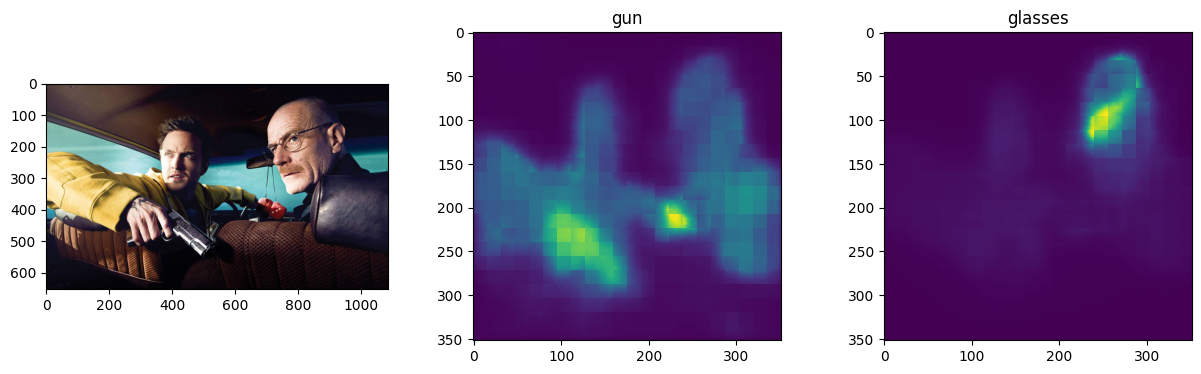

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, len(prompts) + 1, figsize=(15, 4))
ax[0].imshow(imagem)

for i, segmento in enumerate(segmentacao, 1):
    ax[i].imshow(segmento['mask'], cmap='viridis')
    ax[i].set_title(segmento['label'])

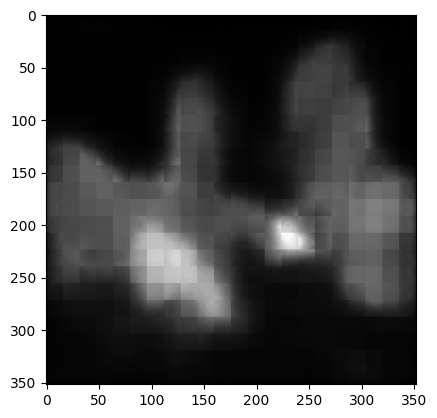

In [28]:
imagem_predicao = segmentacao[0]['mask']
plt.imshow(imagem_predicao, cmap='binary_r')

(array([64323., 12899., 19033., 16536.,  5114.,  1993.,  1755.,  1637.,
          464.,   150.]),
 array([1.51167871e-04, 1.97749790e-02, 3.93987931e-02, 5.90226054e-02,
        7.86464140e-02, 9.82702300e-02, 1.17894039e-01, 1.37517855e-01,
        1.57141671e-01, 1.76765472e-01, 1.96389288e-01]),
 <BarContainer object of 10 artists>)

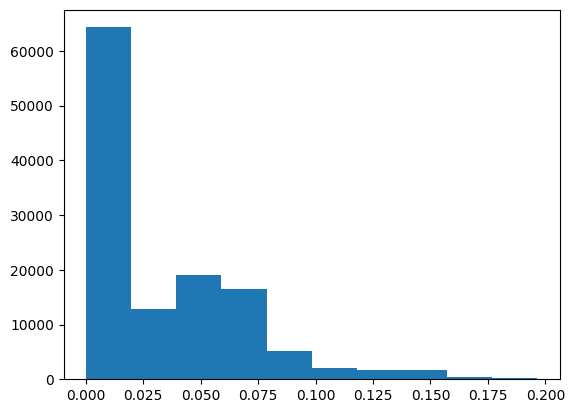

In [29]:
plt.hist(imagem_predicao.ravel())

In [30]:
import numpy as np

threshold = 0.7

mascara_predicao = np.where(imagem_predicao < threshold, 0.0, imagem_predicao)
mascara_predicao = np.where(mascara_predicao > threshold, 255, mascara_predicao)
mascara_predicao = mascara_predicao.astype(int)

(array([     0.,      0.,      0.,      0.,      0., 123904.,      0.,
             0.,      0.,      0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

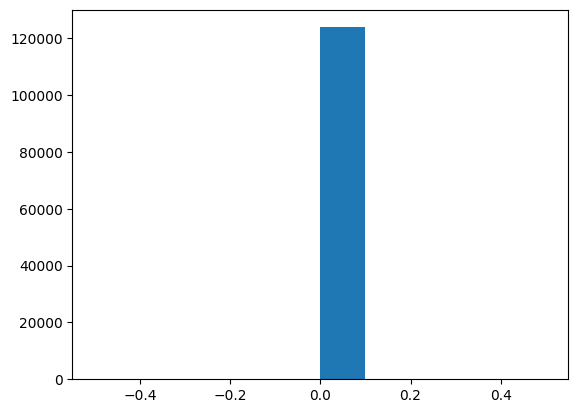

In [31]:
plt.hist(mascara_predicao.ravel())

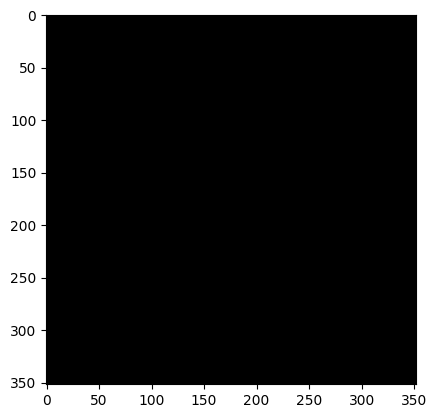

In [32]:
plt.imshow(mascara_predicao, cmap='binary_r')